In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import itertools
import argparse
import pickle
from datetime import datetime
import sys

from sklearn.preprocessing import StandardScaler


In [ ]:
def make_if_not_exists(folder_name) :
    if not os.path.exists(folder_name) :
        os.makedirs(folder_name)

def get_data() :
    '''
    Returns Tx3 values of stock prices
    -------------------------------------------
    col0 - AAPL
    col1 - MSI
    col2 - SBUX
    '''
    df = pd.read_csv('aapl_msi_sbux.csv')
    return df.values

def get_scalar(env):  #to make it more accurate, run it for multiple epis
    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done :
            break
        
    scalar = StandardScaler()
    scalar.fit(states)
    return scalar

In [ ]:
class LinRegression :
    def __init__(self, input_dim, n_action, learning_rate=0.01, momentum=0.9) :
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.Wa = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.ba = np.zeros(n_action)
        
        #momentum terms
        self.vW = 0
        self.vb = 0
        
        self.losses = []
        
    def predict(self, X) :
        assert(len(X.shape) == 2) 
        return X @ self.Wa + self.ba
    
    def sgd(self, X, Y) :
        assert(len(X.shape) == 2)
        
        #total num of values in Y
        num_values = np.prod(Y.shape)
        
        Yhat = self.predict(X)
        gW = 2 * X.T.dot(Yhat - Y) / num_values
        gb = 2 * (Yhat - Y).sum(axis=0) / num_values
        
        #updating momentum terms
        self.vW = self.momentum * self.vW - self.learning_rate * gW
        self.vb = self.momentum * self.vb - self.learning_rate * gb
        
        #updating weights
        self.Wa = self.Wa + self.vW
        self.ba = self.ba + self.vb
        
        mse = np.mean((Yhat - Y)**2)
        self.losses.append(mse)
        
    def load_weights(self, filepath) :
        npz = np.load(filepath)
        self.Wa = npz['Wa']
        self.ba = npz['ba']
        
    def save_weights(self, filepath) :
        np.savez(filepath, Wa=self.Wa, ba=self.ba)

In [122]:
class Environment:
    def __init__(self, data, initial_investment=20000) :
        self.stock_price_history = data
        self.initial_investment = initial_investment
        
        self.n_step, self.n_stocks = self.stock_price_history.shape

        
        self.cur_step = None #pointer
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        
        self.action_space = np.arange(3**self.n_stocks)
        
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=3)))
        
        self.state_dim = self.n_stocks * 2 + 1
        self.reset()
        
        
    def reset(self) :
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stocks)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()
    
    def step(self, action) :
        assert action in self.action_space
        
        old_portfolio_val = self._get_val()
        
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        
        #performing the trade
        self._trade(action)
        
        new_portfolio_val = self._get_val()
        
        #calculating reward
        reward = new_portfolio_val - old_portfolio_val
        
        #checking done flag
        done = self.cur_step == (self.n_step - 1)
        
        #storing the current portfolio value
        info = {'cur_val' : new_portfolio_val}
        
        return self._get_obs(), reward, done, info
    
    def _get_obs(self):
        obs = np.empty(self.state_dim, dtype=np.float32)
        obs[:self.n_stocks] = self.stock_owned
        obs[self.n_stocks:self.n_stocks*2] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs
    
    def _get_val(self) :
        return self.stock_owned @ self.stock_price + self.cash_in_hand
    
    def _trade(self, action) :
        '''
        Trades the action in the environment
        ----------------------------------------
        0 - sell
        1 - hold
        2 - buy
        '''
        action_vec = self.action_list[action]
        # sell_index = [] # stores index of stocks we want to sell
        # buy_index = [] # stores index of stocks we want to buy
        # for i, a in enumerate(action_vec):
        #     if a == 0:
        #         sell_index.append(i)
        #     elif a == 2:
        #         buy_index.append(i)
        sell_index = np.argwhere(np.array(action_vec) == 0).ravel()
        buy_index = np.argwhere(np.array(action_vec) == 2).ravel()
        
        if len(sell_index) > 0:
        # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if len(buy_index) > 0:
        # NOTE: when buying, we will loop through each stock we want to buy,
        #       and buy one share at a time until we run out of cash
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1 # buy one share
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False

In [128]:
class DQNAgent(object) :
    def __init__(self, state_size, action_size) :
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95
        self.epsilon = 1.0 #exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinRegression(state_size, action_size)
        
    def act(self, state) :
        if np.random.rand() <= self.epsilon :
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def train(self, state, action, reward, next_state, done) :
        if done:
            target = reward
        else :
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)
        
        target_full = self.model.predict(state)
        target_full[0, action] = target.item()
        
        self.model.sgd(state, target_full)
        
        if self.epsilon > self.epsilon_min :
            self.epsilon *= self.epsilon_decay
            
    def load(self, name) :
        self.model.load_weights(name)
        
    def save(self, name) :
        self.model.save_weights(name)

In [129]:
def play_one_epsiode(agent, env, is_train, scaler) : 
    state = env.reset()
    # scaler = StandardScaler()
    state = scaler.transform([state])
    done = False
    while not done :
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if is_train == 'train' :
            agent.train(state, action, reward, next_state, done)
        state = next_state
        
    return info['cur_val']

In [130]:
def print_info(episode_number, total_episodes, dct=None):
    arrow_length = 30
    progress = int((episode_number / total_episodes) * arrow_length)
    progress_bar = "=" * progress + ">"
    info_string = "\rEpisode: [{:<30}] {}/{}".format(progress_bar, episode_number, total_episodes)
    if dct is not None:
        info_string += ", {}".format(dct)
    sys.stdout.write(info_string.ljust(100))  # Adjust the total length as needed
    sys.stdout.flush()

In [133]:
def main(args) :
    if __name__ == '__main__' :
        #config
        models_folder = 'linear_rl_trader_models'
        rewards_folder = 'linear_rl_trader_rewards'
        num_epsiodes = 3000
        batch_size  = 32
        initial_investment = 20000

        parser = argparse.ArgumentParser()
        parser.add_argument('-m', '--mode', type=str, required=True, help='either "train" or "test"')
        args = parser.parse_args(args)

        make_if_not_exists(models_folder)
        make_if_not_exists(rewards_folder)

        data = get_data()
        n_timesteps, n_stocks = data.shape

        n_train = n_timesteps // 2

        train_data = data[:n_train]
        test_data = data[n_train:]

        env = Environment(train_data, initial_investment)
        state_size = env.state_dim
        action_size = len(env.action_space)
        agent = DQNAgent(state_size, action_size)
        scaler = get_scalar(env)

        portfolio_value = []

        if args.mode == 'test' :
            with open(os.path.join(models_folder, 'scalar.pkl'), 'rb') as f:
                scalar = pickle.load(f)

            env = Environment(test_data, initial_investment)

            agent.epsilon = 0.01

            agent.load(os.path.join(models_folder, 'linear.npz'))

        for e in range(num_epsiodes) :
            t0 = datetime.now()
            val = play_one_epsiode(agent, env, args.mode, scaler)
            dt = datetime.now() - t0
            print_info(e+1, num_epsiodes, {"value" : f'{val:.2f}', "duration" : f'{(dt.total_seconds() * 1000):.2f} ms'})
            # print(f'Epsiode: {e + 1} / {num_epsiodes}, value: {val:.2f}, duration: [{dt}]ms')
            portfolio_value.append(val)

        if args.mode == 'train' :
            agent.save(os.path.join(models_folder, 'linear.npz'))

            with open(os.path.join(models_folder, 'scalar.pkl'), 'wb') as f:
                pickle.dump(scaler, f)

            plt.plot(agent.model.losses)
            plt.show()
            
        # save portfolio value for each episode
        np.save(f'{rewards_folder}/{args.mode}.npy', portfolio_value)

Episode: [==============================>] 3000/3000, {'value': '49927.81', 'duration': '367.19 ms'}

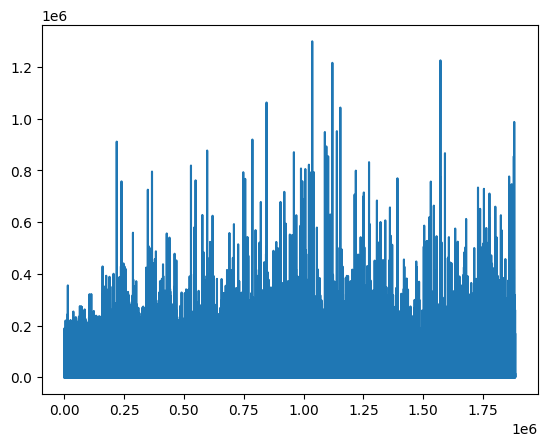

In [134]:
main(['--mode', 'train'])

In [135]:
main(['--mode', 'test'])

Episode: [==============================>] 3000/3000, {'value': '29574.00', 'duration': '91.83 ms'}